Сначала как-то рандомно скачиваю архив и распаковываю его для тестирования

In [4]:
!wget https://sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru:443/wildlife_project/whale_leus/Whale%20ReId%202.7z

--2025-04-25 03:52:26--  https://sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru/wildlife_project/whale_leus/Whale%20ReId%202.7z
Resolving sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru (sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru)... 46.243.206.35, 46.243.206.34
Connecting to sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru (sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru)|46.243.206.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7624464497 (7.1G) [application/x-7z-compressed]
Saving to: ‘Whale ReId 2.7z’

Whale ReId 2.7z     100%[===================>]   7.10G  21.9MB/s    in 5m 57s  

2025-04-25 03:58:24 (20.4 MB/s) - ‘Whale ReId 2.7z’ saved [7624464497/7624464497]



In [5]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 32.6 MB/s eta 0:00:00


In [6]:
import py7zr
import os

with py7zr.SevenZipFile('/content/Whale ReId 2.7z', mode='r') as archive:
    all_files = archive.getnames()

In [7]:
archive_path = "/content/Whale ReId 2.7z"
extract_dir = "/content/Whales"

os.makedirs(extract_dir, exist_ok=True)

with py7zr.SevenZipFile(archive_path, mode='r') as archive:
    archive.extractall(path=extract_dir)

In [8]:
!find /content/Whales -type f -name "*.png" -delete

In [9]:
import shutil
from tqdm import tqdm
import random

def split_whale_data(source_dir, train_ratio=0.8):
    whales = os.listdir(source_dir)
    for whale in tqdm(whales):
        whale_path = os.path.join(source_dir, whale)
        dates = os.listdir(whale_path)
        random.shuffle(dates)

        total_photos = sum(
            len(os.listdir(os.path.join(whale_path, date)))
            for date in dates
        )
        target_test_photos = int(total_photos * (1 - train_ratio))

        train_dates, test_dates = [], []
        test_photo_count = 0

        for date in dates:
            date_photos = len(os.listdir(os.path.join(whale_path, date)))
            if test_photo_count + date_photos <= target_test_photos:
                test_dates.append(date)
                test_photo_count += date_photos
            else:
                train_dates.append(date)

        if not test_dates:
            test_dates = [random.choice(dates)]
            train_dates = [d for d in dates if d not in test_dates]

        for date in train_dates:
            src = os.path.join(whale_path, date)
            dst = os.path.join("whales_processed/train", whale, date)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copytree(src, dst)

        for date in test_dates:
            src = os.path.join(whale_path, date)
            dst = os.path.join("whales_processed/test", whale, date)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copytree(src, dst)

split_whale_data("/content/Whales/Whale ReId 2")

100%|██████████| 102/102 [02:13<00:00,  1.30s/it]


In [10]:
def check_balance(root_dir, min_train_percent=70, max_train_percent=90):
    stats = {}
    deleted_whales = []

    for split in ["train", "test"]:
        split_path = os.path.join(root_dir, split)
        if not os.path.exists(split_path):
            continue

        for whale in os.listdir(split_path):
            if whale not in stats:
                stats[whale] = {"train": {"photos": 0, "dates": 0},
                               "test": {"photos": 0, "dates": 0}}

            whale_path = os.path.join(split_path, whale)
            photo_count = 0
            date_count = 0

            for date in os.listdir(whale_path):
                date_path = os.path.join(whale_path, date)
                if os.path.isdir(date_path):
                    date_count += 1
                    photos = [f for f in os.listdir(date_path)
                             if f.lower().endswith(('.jpg'))]
                    photo_count += len(photos)

            stats[whale][split]["photos"] = photo_count
            stats[whale][split]["dates"] = date_count

    for whale, data in stats.copy().items():
        total_photos = data["train"]["photos"] + data["test"]["photos"]
        total_dates = data["train"]["dates"] + data["test"]["dates"]

        if total_photos == 0 or total_dates <= 2:
            for split in ["train", "test"]:
                whale_path = os.path.join(root_dir, split, whale)
                if os.path.exists(whale_path):
                    shutil.rmtree(whale_path)

            deleted_whales.append(whale)
            del stats[whale]
            continue

        train_percent = (data["train"]["photos"] / total_photos) * 100

        if not (min_train_percent <= train_percent <= max_train_percent):
            for split in ["train", "test"]:
                whale_path = os.path.join(root_dir, split, whale)
                if os.path.exists(whale_path):
                    shutil.rmtree(whale_path)

            deleted_whales.append(whale)
            del stats[whale]

    # Вывод статистики
    print("\n{:<15} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
        "Кит", "Train фото", "Test фото", "Train %", "Test %", "Даты (train/test)"))
    print("-" * 70)

    for whale, data in stats.items():
        total = data["train"]["photos"] + data["test"]["photos"]
        train_p = (data["train"]["photos"] / total) * 100
        test_p = (data["test"]["photos"] / total) * 100

        print("{:<15} {:<10} {:<10} {:<10.1f}% {:<10.1f}% {:<10}".format(
            whale,
            data["train"]["photos"],
            data["test"]["photos"],
            train_p,
            test_p,
            f"{data['train']['dates']}/{data['test']['dates']}"
        ))

    # Вывод удаленных папок
    if deleted_whales:
        print("\nУдаленные папки с плохим балансом или малым числом дат:")
        for whale in deleted_whales:
            print(f"- {whale}")
    else:
        print("\nВсе папки соответствуют критериям!")

# Пример использования
check_balance("whales_processed", min_train_percent=70, max_train_percent=90)


Кит             Train фото Test фото  Train %    Test %     Даты (train/test)
----------------------------------------------------------------------
21_23_frames    185        42         81.5      % 18.5      % 5/3       
20_42_frames    134        45         74.9      % 25.1      % 2/1       
21_16_frames    32         5          86.5      % 13.5      % 1/2       
22_04_frames    99         20         83.2      % 16.8      % 2/3       
21_55_frames    61         10         85.9      % 14.1      % 4/1       
21_34_frames    312        58         84.3      % 15.7      % 3/3       
21_09_frames    249        46         84.4      % 15.6      % 3/7       
21_35_frames    92         21         81.4      % 18.6      % 4/3       
21_02_frames    232        54         81.1      % 18.9      % 4/5       
20_39_frames    323        73         81.6      % 18.4      % 4/4       
20_25_frames    402        79         83.6      % 16.4      % 6/1       
20_73_frames    102        23         81.6     

In [11]:
def flatten_directory_structure(root_dir):
    for split in ["train", "test"]:
        split_path = os.path.join(root_dir, split)
        if not os.path.exists(split_path):
            continue

        for whale in tqdm(os.listdir(split_path), desc=f"Processing {split}"):
            whale_path = os.path.join(split_path, whale)

            for root, dirs, files in os.walk(whale_path):
                for file in files:
                    if file.lower().endswith(('.jpg')):
                        src_path = os.path.join(root, file)

                        date_folder = os.path.basename(root)
                        new_filename = f"{date_folder}_{file}"

                        dest_path = os.path.join(whale_path, new_filename)

                        shutil.move(src_path, dest_path)

            for root, dirs, files in os.walk(whale_path, topdown=False):
                for dir in dirs:
                    dir_path = os.path.join(root, dir)
                    if not os.listdir(dir_path):
                        os.rmdir(dir_path)

flatten_directory_structure("whales_processed")

Processing test: 100%|██████████| 59/59 [00:00<00:00, 571.80it/s]


In [12]:
import shutil
from tqdm import tqdm
import random

def keep_common_folders(dataset_path, max_folders_to_keep=8):
    """Оставляет только указанное количество общих папок в train/test"""
    train_path = os.path.join(dataset_path, "train")
    test_path = os.path.join(dataset_path, "test")

    train_folders = set(os.listdir(train_path)) if os.path.exists(train_path) else set()
    test_folders = set(os.listdir(test_path)) if os.path.exists(test_path) else set()

    common_folders = list(train_folders & test_folders)
    print(f"Найдено общих папок: {len(common_folders)}")

    if len(common_folders) < max_folders_to_keep:
        print(f"Внимание: доступно только {len(common_folders)} общих папок")
        max_folders_to_keep = len(common_folders)

    folders_to_keep = random.sample(common_folders, max_folders_to_keep)
    print(f"Сохраняем папки: {', '.join(folders_to_keep)}")

    if os.path.exists(train_path):
        for folder in tqdm(os.listdir(train_path), desc="Обработка train"):
            if folder not in folders_to_keep:
                shutil.rmtree(os.path.join(train_path, folder))
    if os.path.exists(test_path):
        for folder in tqdm(os.listdir(test_path), desc="Обработка test"):
            if folder not in folders_to_keep:
                shutil.rmtree(os.path.join(test_path, folder))

dataset_path = "whales_processed"
keep_common_folders(
    dataset_path=dataset_path,
    max_folders_to_keep=30
)

Найдено общих папок: 59
Сохраняем папки: 20_26_frames, 20_55_frames, 20_01_frames, 22_07_frames, 20_42_frames, 20_43_frames, 20_37_frames, 20_56_frames, 20_48_frames, 20_39_frames, 20_21_frames, 21_27_frames, 21_05_frames, 21_34_frames, 20_45_frames, 20_70_frames, 20_02_frames, 20_40_frames, 20_05_frames, 20_04_frames, 21_37_frames, 21_55_frames, 21_09_frames, 21_02_frames, 20_03_frames, 21_06_frames, 21_67_frames, 21_14_frames, 20_14_frames, 21_36_frames


Обработка test: 100%|██████████| 59/59 [00:00<00:00, 1094.58it/s]


### Далее начинается работа с предсказаниями

In [1]:
!pip install faiss-gpu-cu12

In [2]:
!pip uninstall numpy timm torch torchvision -y
!pip install numpy==1.23.5 torch torchvision timm

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: timm 1.0.15
Uninstalling timm-1.0.15:
  Successfully uninstalled timm-1.0.15
Found existing installation: torch 2.7.0
Uninstalling torch-2.7.0:
  Successfully uninstalled torch-2.7.0
Found existing installation: torchvision 0.22.0
Uninstalling torchvision-0.22.0:
  Successfully uninstalled torchvision-0.22.0
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached torch-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached timm-1.0.15-py3-none-any.whl.metadata (52 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
Using cached torch-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl (865.2 MB)
Using cached torchvision-0.22.0-cp311-cp311-m

In [3]:
import os
import faiss
import numpy as np
import torch
import timm
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score

In [33]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_PATH = "whales_processed"
MODEL_NAME = "hf-hub:BVRA/MegaDescriptor-S-224"
IMAGE_SIZE = 224
#384
model = timm.create_model(MODEL_NAME, pretrained=True).to(DEVICE)
model.eval()

transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [14]:
def get_embedding(image_path):
    """Получение эмбеддинга для одного изображения"""
    img = Image.open(image_path).convert('RGB')
    tensor = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        features = model(tensor)
    return features.cpu().numpy().flatten()

In [15]:
def build_faiss_index(folder_path):
    """Построение FAISS индекса"""
    embeddings = []
    paths = []

    for root, _, files in os.walk(folder_path):
        for file in tqdm(files, desc=f"Обработка {os.path.basename(root)}"):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, file)
                emb = get_embedding(path)
                if emb is not None:
                    embeddings.append(emb)
                    paths.append(path)

    dimension = embeddings[0].shape[0]
    index = faiss.IndexFlatL2(dimension)
    index.add(np.array(embeddings).astype('float32'))

    return index, paths

In [16]:
def search_similar(query_path, index, paths, k=5):
    """Поиск похожих изображений"""
    query_emb = get_embedding(query_path)
    if query_emb is None:
        return []

    distances, indices = index.search(np.array([query_emb]).astype('float32'), k)
    return [(paths[i], distances[0][j]) for j, i in enumerate(indices[0])]

In [17]:
import matplotlib.pyplot as plt

def show_results(query_path, results):
    """Визуализация найденных изображений"""
    plt.figure(figsize=(15,5))

    plt.subplot(1, 6, 1)
    plt.imshow(Image.open(query_path))
    plt.title("Query Image")

    for i, (path, distance) in enumerate(results, 1):
        plt.subplot(1, 6, i+1)
        plt.imshow(Image.open(path))
        plt.title(f"#{i}\n{distance:.2f}")

    plt.tight_layout()
    plt.show()

In [18]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns

def evaluate_model(test_folder, index, paths, k_values=(1, 5)):
    """Расширенная оценка модели с несколькими метриками"""
    y_true = []
    y_pred = []
    all_scores = {k: [] for k in k_values}

    for root, _, files in os.walk(test_folder):
        for file in tqdm(files, desc="Оценка модели"):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                query_path = os.path.join(root, file)
                true_label = os.path.basename(root)

                results = search_similar(query_path, index, paths, k=max(k_values))
                if not results:
                    continue

                retrieved_labels = [os.path.basename(os.path.dirname(p[0])) for p in results]
                for k in k_values:
                    all_scores[k].append(1 if true_label in retrieved_labels[:k] else 0)

                pred_label = retrieved_labels[0]
                y_true.append(true_label)
                y_pred.append(pred_label)

    print("\nКлассификационные метрики (top-1):")
    print(classification_report(y_true, y_pred, zero_division=0))

    print("\nМетрики поиска:")
    for k in k_values:
        recall_at_k = np.mean(all_scores[k])
        print(f"Recall@{k}: {recall_at_k:.2%}")

    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return {
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted'),
        'accuracy': accuracy_score(y_true, y_pred),
        'recall@k': {k: np.mean(all_scores[k]) for k in k_values}
    }

In [34]:
train_index, train_paths = build_faiss_index(os.path.join(DATA_PATH, "train"))

Обработка train: 0it [00:00, ?it/s]

Обработка 20_42_frames:   0%|          | 0/134 [00:00<?, ?it/s]

Обработка 21_55_frames:   0%|          | 0/61 [00:00<?, ?it/s]

Обработка 21_34_frames:   0%|          | 0/312 [00:00<?, ?it/s]

Обработка 21_09_frames:   0%|          | 0/249 [00:00<?, ?it/s]

Обработка 21_02_frames:   0%|          | 0/232 [00:00<?, ?it/s]

Обработка 20_39_frames:   0%|          | 0/323 [00:00<?, ?it/s]

Обработка 20_37_frames:   0%|          | 0/249 [00:00<?, ?it/s]

Обработка 21_27_frames:   0%|          | 0/274 [00:00<?, ?it/s]

Обработка 21_05_frames:   0%|          | 0/133 [00:00<?, ?it/s]

Обработка 20_45_frames:   0%|          | 0/465 [00:00<?, ?it/s]

Обработка 22_07_frames:   0%|          | 0/396 [00:00<?, ?it/s]

Обработка 21_06_frames:   0%|          | 0/53 [00:00<?, ?it/s]

Обработка 20_48_frames:   0%|          | 0/406 [00:00<?, ?it/s]

Обработка 21_37_frames:   0%|          | 0/72 [00:00<?, ?it/s]

Обработка 20_02_frames:   0%|          | 0/133 [00:00<?, ?it/s]

Обработка 20_43_frames:   0%|          | 0/448 [00:00<?, ?it/s]

Обработка 20_70_frames:   0%|          | 0/346 [00:00<?, ?it/s]

Обработка 21_14_frames:   0%|          | 0/123 [00:00<?, ?it/s]

Обработка 20_56_frames:   0%|          | 0/548 [00:00<?, ?it/s]

Обработка 20_21_frames:   0%|          | 0/715 [00:00<?, ?it/s]

Обработка 20_40_frames:   0%|          | 0/591 [00:00<?, ?it/s]

Обработка 20_05_frames:   0%|          | 0/64 [00:00<?, ?it/s]

Обработка 20_26_frames:   0%|          | 0/835 [00:00<?, ?it/s]

Обработка 20_55_frames:   0%|          | 0/859 [00:00<?, ?it/s]

Обработка 20_03_frames:   0%|          | 0/216 [00:00<?, ?it/s]

Обработка 20_14_frames:   0%|          | 0/1098 [00:00<?, ?it/s]

Обработка 21_67_frames:   0%|          | 0/182 [00:00<?, ?it/s]

Обработка 21_36_frames:   0%|          | 0/66 [00:00<?, ?it/s]

Обработка 20_01_frames:   0%|          | 0/333 [00:00<?, ?it/s]

Обработка 20_04_frames:   0%|          | 0/852 [00:00<?, ?it/s]

Оценка модели: 0it [00:00, ?it/s]

Оценка модели:   0%|          | 0/45 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/10 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/58 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/46 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/54 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/73 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/53 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/68 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/31 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/95 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/68 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/9 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/58 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/17 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/24 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/95 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/82 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/25 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/126 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/103 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/142 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/15 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/207 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/213 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/52 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/217 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/44 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/11 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/55 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/155 [00:00<?, ?it/s]


Классификационные метрики (top-1):
              precision    recall  f1-score   support

20_01_frames       0.70      0.47      0.57        55
20_02_frames       0.95      0.79      0.86        24
20_03_frames       0.44      0.94      0.60        52
20_04_frames       0.72      0.80      0.76       155
20_05_frames       0.82      0.93      0.88        15
20_14_frames       0.08      0.07      0.07       217
20_21_frames       0.27      0.08      0.12       103
20_26_frames       0.93      0.52      0.67       207
20_37_frames       0.70      0.89      0.78        53
20_39_frames       0.65      0.23      0.34        73
20_40_frames       0.75      0.93      0.83       142
20_42_frames       0.71      0.76      0.73        45
20_43_frames       0.73      1.00      0.84        95
20_45_frames       0.73      0.79      0.76        95
20_48_frames       0.77      1.00      0.87        58
20_55_frames       0.79      0.77      0.78       213
20_56_frames       0.72      1.00      0.83  

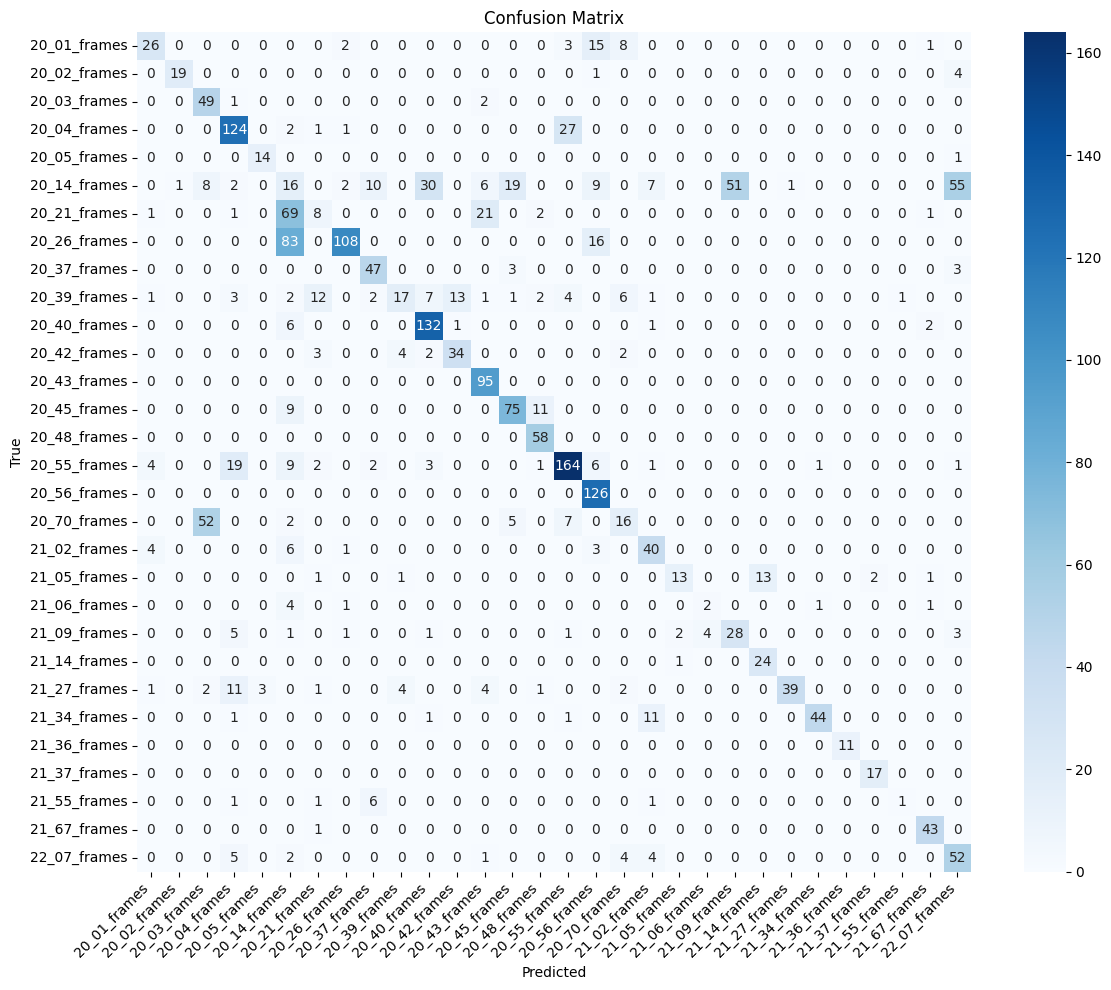

{'precision': 0.6483657136673743, 'recall': 0.6406041759218125, 'f1': 0.6196683407973431, 'accuracy': 0.6406041759218125, 'recall@k': {1: 0.6406041759218125, 3: 0.6974677920924034, 5: 0.7254553531763661, 7: 0.7445579742336739}}


In [35]:
metrics = evaluate_model(
    test_folder=os.path.join(DATA_PATH, "test"),
    index=train_index,
    paths=train_paths,
    k_values=(1,3,5,7)
)
print(metrics)

### Всё, тестирование завершено

### Далее работа над семплером

Из-за дизбаланса классов, который нашел Кирилл, нам необходимо по разному работать с файлами которые пойдут в train для дообучения трансформера. мы хотим чтобы картинок каждого класса было одинакого, а значит в классах, где мало картинок каждую надо брать много раз. Из-за этого аугментация будет очень агрессивная, чтобы картинка была каждый раз разная

In [ ]:
jpg_counts

{'extracted_folder/Whale ReId 2/20_01_frames/crop1_DJI_0481': 28,
 'extracted_folder/Whale ReId 2/20_01_frames/crop_DJI_0001': 120,
 'extracted_folder/Whale ReId 2/20_01_frames/crop2_DJI_0481': 80,
 'extracted_folder/Whale ReId 2/20_01_frames/crop1_DJI_0002': 11,
 'extracted_folder/Whale ReId 2/20_01_frames/crop3_DJI_0002': 23,
 'extracted_folder/Whale ReId 2/20_01_frames/crop2_DJI_0002': 16,
 'extracted_folder/Whale ReId 2/20_01_frames/crop4_DJI_0002': 44,
 'extracted_folder/Whale ReId 2/20_01_frames/crop3_DJI_0481': 66}

In [ ]:
max_count = max(jpg_counts.values())
max_count

120

In [ ]:
# Определяем пороги
threshold_low = 0.25 * max_count
threshold_high = 0.75 * max_count

print("Пороги для аугментаций:")
print(f"Агрессивные: < {threshold_low}")
print(f"Умеренные: {threshold_low} - {threshold_high}")
print(f"Базовые: > {threshold_high}")

Пороги для аугментаций:
Агрессивные: < 30.0
Умеренные: 30.0 - 90.0
Базовые: > 90.0


Это был пример как мы будем определять пороги

# Отсюда идут модули по обучению

In [23]:
!pip install pytorch_metric_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 5.0 MB/s eta 0:00:00


In [24]:
import os
import random
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data.sampler import Sampler
import timm
import torch.nn as nn
from pytorch_metric_learning import losses, miners
from tqdm.auto import tqdm

In [ ]:
transform_aggressive = A.Compose([
    A.RandomRotate90(p=0.6),
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.2),
    A.Resize(224, 224),
    A.CoarseDropout(max_holes=5, max_height=20, max_width=20, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

transform_moderate = A.Compose([
    A.RandomRotate90(p=0.3),
    A.HorizontalFlip(p=0.3),
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

transform_basic = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

<ipython-input-6-fcb65b63b755>:6: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=5, max_height=20, max_width=20, p=0.3),


In [ ]:
class BalancedDataGenerator(Dataset):
    def __init__(self, dataset, class_counts, max_count, transform_aggressive, transform_moderate, transform_basic):
        self.dataset = dataset
        self.class_counts = class_counts
        self.max_count = max_count
        self.transform_aggressive = transform_aggressive
        self.transform_moderate = transform_moderate
        self.transform_basic = transform_basic

        self.class_to_images = defaultdict(list)
        for img_path, label in dataset.imgs:
            self.class_to_images[label].append(img_path)

    def __len__(self):
        return self.max_count * len(self.class_counts)

    def __getitem__(self, idx):
        class_idx = idx // self.max_count
        image_idx = idx % self.max_count

        label = list(self.class_counts.keys())[class_idx]
        images = self.class_to_images[label]

        if image_idx >= len(images):
            img_path = random.choice(images)
            image = Image.open(img_path).convert('RGB')
            if self.class_counts[label] < 0.25 * self.max_count:
                transform = self.transform_aggressive
            elif self.class_counts[label] < 0.75 * self.max_count:
                transform = self.transform_moderate
            else:
                transform = self.transform_basic

            image_np = np.array(image)
            augmented = transform(image=image_np)
            image = augmented['image']
        else:
            img_path = images[image_idx]
            image = Image.open(img_path).convert('RGB')
            image_np = np.array(image)
            augmented = self.transform_basic(image=image_np)
            image = augmented['image']

        return image, label

In [ ]:
train_dataset = ImageFolder(root="/content/whales_processed/train")
test_dataset = ImageFolder(root="/content/whales_processed/test")

def get_class_counts(dataset):
    counts = defaultdict(int)
    for _, label in dataset.samples:
        counts[label] += 1
    return dict(counts)

train_counts = get_class_counts(train_dataset)
test_counts = get_class_counts(test_dataset)

print("Train counts:", train_counts)
print("Test counts:", test_counts)

Train counts: {0: 326, 1: 275, 2: 1098, 3: 101, 4: 265, 5: 448, 6: 848, 7: 487, 8: 343, 9: 116, 10: 53, 11: 278, 12: 92, 13: 99, 14: 113}
Test counts: {0: 62, 1: 53, 2: 217, 3: 23, 4: 37, 5: 95, 6: 96, 7: 100, 8: 85, 9: 26, 10: 9, 11: 64, 12: 21, 13: 20, 14: 24}


In [ ]:
train_generator = BalancedDataGenerator(
    dataset=train_dataset,
    class_counts=train_counts,
    max_count=max(train_counts.values()),
    transform_aggressive = transform_aggressive,
    transform_moderate = transform_moderate,
    transform_basic = transform_basic
)

In [ ]:
print(max(train_counts.values()))
print(len(train_generator))
print(len(train_counts.keys()))
print(len(train_generator) / max(train_counts.values()))
#Всё верно

1098
16470
15
15.0


In [26]:
def load_embedding_model(model_name="hf-hub:BVRA/MegaDescriptor-L-384",
                         embedding_size=512,
                         device="cuda"):
    class EmbeddingModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.backbone = timm.create_model(model_name, pretrained=True)
            self.projection = nn.Linear(self.backbone.num_features, embedding_size)

        def forward(self, x):
            features = self.backbone(x)
            embeddings = self.projection(features)
            return nn.functional.normalize(embeddings, p=2, dim=1)

    model = EmbeddingModel().to(device)
    return model

In [ ]:
def train_model(model, train_loader, epochs=10, lr=1e-4, device="cuda"):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_func = losses.TripletMarginLoss(margin=0.2)
    miner = miners.TripletMarginMiner(margin=0.1)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        batch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for images, labels in batch_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            embeddings = model(images)

            if torch.allclose(embeddings, embeddings[0], atol=1e-5):
                print("Предупреждение: все эмбеддинги идентичны!")
                continue

            triplets = miner(embeddings, labels)

            if len(triplets) == 0:
                print("Нет валидных триплетов!")
                continue
            print(len(triplets), triplets)
            loss = loss_func(embeddings, labels, triplets)
            print(labels)
            print(loss)
            if not torch.isfinite(loss):
                print(f"Обнаружен NaN в loss: {loss.item()}")
                continue

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            batch_bar.set_postfix(loss=loss.item(), avg_loss=total_loss/(batch_bar.n+1))

        batch_bar.close()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f}")

    return model

In [ ]:
def train_model(model, train_loader, epochs=10, lr=1e-4, device="cuda"):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_func = losses.TripletMarginLoss(margin=0.2)
    miner = miners.TripletMarginMiner(margin=0.1)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        skipped_batches = 0

        batch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for images, labels in batch_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            embeddings = model(images)

            triplets = miner(embeddings, labels)

            if isinstance(triplets, tuple) and len(triplets) > 0 and len(triplets[0]) == 0:
                #print("\nНет валидных триплетов!")
                skipped_batches += 1
                batch_bar.set_postfix(loss="skip (no triplets)", skipped=skipped_batches)
                continue

            #print(len(triplets), triplets)

            loss = loss_func(embeddings, labels, triplets)

            #print(labels)
            #print(loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            batch_bar.set_postfix(
                loss=loss.item(),
                avg_loss=total_loss/(batch_bar.n + 1 - skipped_batches),
                skipped=skipped_batches
            )

        batch_bar.close()

        avg_loss = total_loss / (len(train_loader) - skipped_batches) if (len(train_loader) - skipped_batches) > 0 else 0
        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Skipped: {skipped_batches}")

    return model

In [ ]:
train_loader = DataLoader(
    train_generator,
    batch_size=7,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

In [29]:
model = load_embedding_model(
        model_name="hf-hub:BVRA/MegaDescriptor-S-224",
        embedding_size=128,
        device="cuda"
    )

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/290M [00:00<?, ?B/s]

In [30]:
model.load_state_dict(torch.load('/content/weights_model.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
model = train_model(model=model, train_loader=train_loader, epochs=6, device="cuda")

Epoch 1/6:   0%|          | 0/2353 [00:00<?, ?it/s]

3 (tensor([0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
        6, 6, 6], device='cuda:0'), tensor([3, 3, 3, 4, 4, 4, 4, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 3, 3, 3, 6, 6, 6,
        5, 5, 5], device='cuda:0'), tensor([2, 5, 6, 1, 2, 5, 6, 1, 2, 5, 6, 1, 5, 6, 1, 2, 5, 6, 1, 5, 6, 1, 3, 4,
        1, 3, 4], device='cuda:0'))
tensor([ 6, 11,  0,  6,  6, 10, 10], device='cuda:0')
tensor(0.2972, device='cuda:0', grad_fn=<MeanBackward0>)
3 (tensor([4, 4, 4, 4, 5, 5, 5, 5], device='cuda:0'), tensor([5, 5, 5, 5, 4, 4, 4, 4], device='cuda:0'), tensor([0, 1, 2, 3, 0, 1, 2, 3], device='cuda:0'))
tensor([ 8,  5,  0, 11,  4,  4, 11], device='cuda:0')
tensor(0.1744, device='cuda:0', grad_fn=<MeanBackward0>)
3 (tensor([1, 6], device='cuda:0'), tensor([6, 1], device='cuda:0'), tensor([0, 0], device='cuda:0'))
tensor([12,  4,  1,  0,  6,  9,  4], device='cuda:0')
tensor(0.2324, device='cuda:0', grad_fn=<MeanBackward0>)
3 (tensor([2, 3], device='cuda:0'), tensor([3, 2], device=

Обработка train: 0it [00:00, ?it/s]

Обработка 20_25_frames:   0%|          | 0/401 [00:00<?, ?it/s]

Обработка 20_22_frames:   0%|          | 0/978 [00:00<?, ?it/s]

Обработка 20_19_frames:   0%|          | 0/601 [00:00<?, ?it/s]

Обработка 20_11_frames:   0%|          | 0/280 [00:00<?, ?it/s]

Обработка 20_34_frames:   0%|          | 0/193 [00:00<?, ?it/s]

Обработка 21_86_frames:   0%|          | 0/163 [00:00<?, ?it/s]

Обработка 21_06_frames:   0%|          | 0/51 [00:00<?, ?it/s]

Обработка 20_56_frames:   0%|          | 0/548 [00:00<?, ?it/s]

Обработка 20_48_frames:   0%|          | 0/406 [00:00<?, ?it/s]

Обработка 21_02_frames:   0%|          | 0/232 [00:00<?, ?it/s]

Оценка модели: 0it [00:00, ?it/s]

Оценка модели:   0%|          | 0/80 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/192 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/74 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/48 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/47 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/11 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/126 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/58 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/54 [00:00<?, ?it/s]


Классификационные метрики (top-1):
              precision    recall  f1-score   support

20_11_frames       1.00      0.67      0.80        48
20_19_frames       0.06      0.05      0.06        74
20_22_frames       0.95      0.77      0.85       192
20_25_frames       0.55      0.97      0.70        80
20_34_frames       0.00      0.00      0.00        47
20_48_frames       1.00      0.91      0.95        58
20_56_frames       0.94      1.00      0.97       126
21_02_frames       0.79      0.70      0.75        54
21_06_frames       0.19      1.00      0.31        11
21_86_frames       1.00      1.00      1.00        23

    accuracy                           0.72       713
   macro avg       0.65      0.71      0.64       713
weighted avg       0.73      0.72      0.71       713


Метрики поиска:
Recall@1: 71.81%
Recall@3: 74.61%
Recall@5: 75.46%


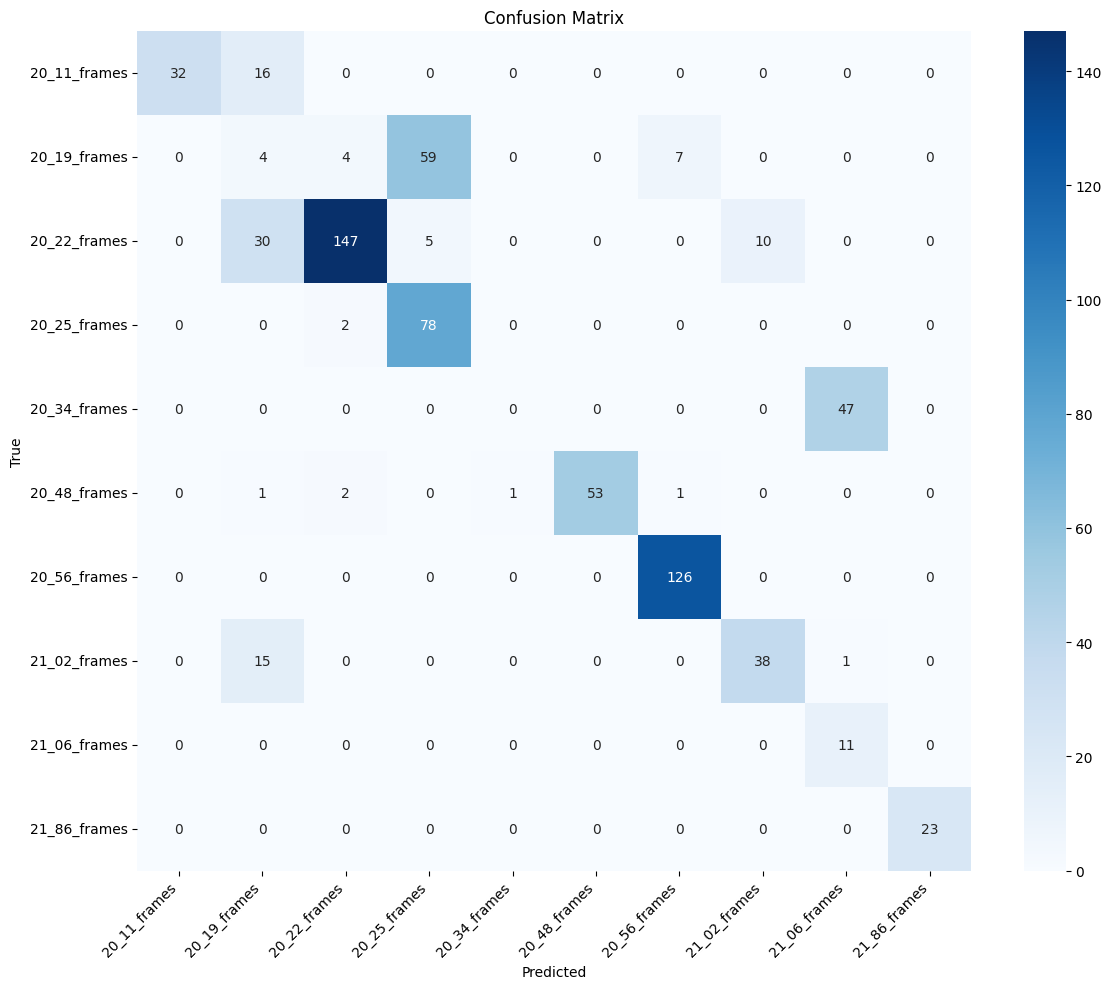

{'precision': 0.7332360342710382, 'recall': 0.7180925666199158, 'f1': 0.7092875743549175, 'accuracy': 0.7180925666199158, 'recall@k': {1: 0.7180925666199158, 3: 0.7461430575035063, 5: 0.7545582047685835}}


In [ ]:
DATA_PATH = "whales_processed"
IMAGE_SIZE = 224

transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_index, train_paths = build_faiss_index(os.path.join(DATA_PATH, "train"))

metrics = evaluate_model(
    test_folder=os.path.join(DATA_PATH, "test"),
    index=train_index,
    paths=train_paths,
    k_values=(1,3,5)
)
print(metrics)